### 데이터셋
* 허깅페이스 데이터셋 처음 사용하기

In [1]:
from huggingface_hub import list_datasets

In [2]:
all_datasets = [ds.id for ds in list_datasets()]

In [3]:
len(all_datasets), all_datasets[:10]

(182505,
 ['amirveyseh/acronym_identification',
  'ade-benchmark-corpus/ade_corpus_v2',
  'UCLNLP/adversarial_qa',
  'Yale-LILY/aeslc',
  'nwu-ctext/afrikaans_ner_corpus',
  'fancyzhx/ag_news',
  'allenai/ai2_arc',
  'google/air_dialogue',
  'komari6/ajgt_twitter_ar',
  'legacy-datasets/allegro_reviews'])

In [4]:
# emotion 데이터셋 로드
from datasets import load_dataset
emotion = load_dataset('emotion')

C:\Users\knuyh\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [5]:
emotion

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
train_set = emotion['train']
train_set[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [7]:
train_set.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

* 데이터셋에서 데이터프레임으로

In [8]:
emotion.set_format(type = 'pandas') # 출력 포맷 변경
df = emotion['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [9]:
def label_int2str(row):
    return emotion["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


* 클래스 분포 살펴보기

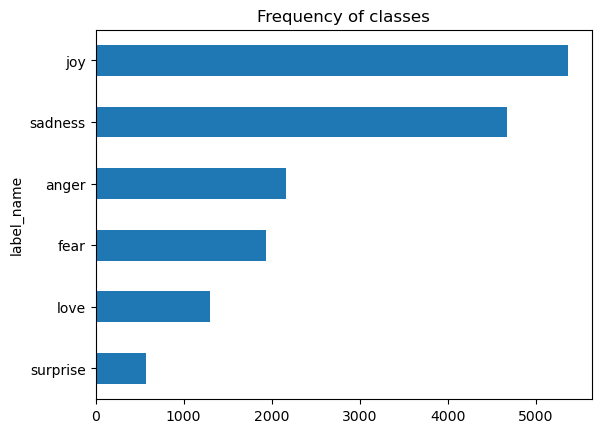

In [10]:
import matplotlib.pyplot as plt

df['label_name'].value_counts(ascending = True).plot.barh()
plt.title('Frequency of classes')
plt.show()

심각한 데이터 불균형  
-> 해결 방법(3)
   * 소수 클래스 랜덤하게 오버샘플링
   * 다수 클래스 랜덤하게 언더샘플링
   * 클래스의 대표성 부족하면, 레이블된 데이터 더 많이 수집하기

* 트윗 길이 확인

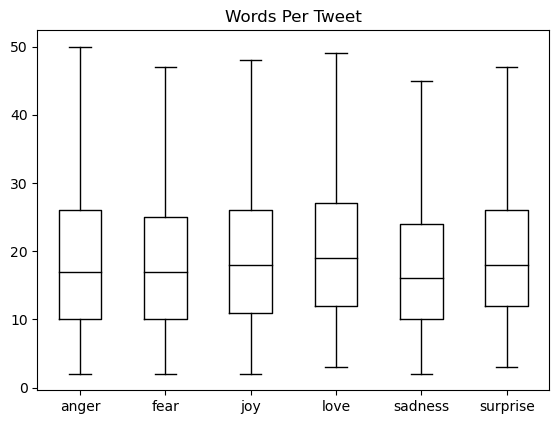

In [11]:
# 토큰 = text의 기본 단위
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

각 감정의 트윗 길이는 15개 단어 정도  
가장 긴 트윗도 DistilBERT의 최대 문맥 크기(512)보다 작다.

In [12]:
# 데이터셋 출력 포맷 초기화
emotion.reset_format()

### 텍스트에서 토큰으로
- DistilBERT 같은 트랜스포머 모델은 원시 문자열을 입력으로 받지 못한다. 텍스트가 토큰화되어 수치 벡터로 인코딩됐다고 가정
- 토큰화 : 문자열을 모델이 사용하는 기본 단위로 분할

* 문자 토큰화

In [13]:
text = 'Tokenizing text is a core task of NLP.'
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


In [14]:
token2idx = {ch : idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


In [15]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


In [16]:
# 원 핫벡터의 2D텐서로 변경
import pandas as pd

categorical_df = pd.DataFrame(
    {"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0,1,2]})
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


In [17]:
pd.get_dummies(categorical_df['Name'])

,Bumblebee,Megatron,Optimus Prime
0,True,False,False
1,False,False,True
2,False,True,False


In [18]:
import torch
import torch.nn.functional as F

In [19]:
input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes = len(token2idx))
one_hot_encodings.shape # 38개 입력 토큰 각각에 20차원

torch.Size([38, 20])

In [20]:
print(f"토큰: {tokenized_text[0]}")
print(f"텐서 인덱스: {input_ids[0]}")
print(f"원-핫 인코딩: {one_hot_encodings[0]}")

토큰: T
텐서 인덱스: 5
원-핫 인코딩: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


* 단어 토큰화

In [21]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


* 부분단어 토큰화
: 문자 토큰화 + 단어 토큰화

In [22]:
from transformers import AutoTokenizer

In [23]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt) # 사전 훈련된 모델 로드

In [24]:
# 특정 클래스 수동으로도 로드 가능
from transformers import DistilBertTokenizer
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [25]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [26]:
# 다시 토큰으로 변환
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


체크 포인트의 특징
  * 소문자로 변환
  * 특수 토큰 [CLS], [SEP] 시작 끝 토큰 추가
  * tokenizing = token + ##izing : 자주 등장하지 않는 단어이기에 나뉨 (# : 앞의 문자열이 공백이 아님)

In [27]:
tokenizer.convert_tokens_to_string(tokens)

'[CLS] tokenizing text is a core task of nlp. [SEP]'

In [28]:
tokenizer.vocab_size, tokenizer.model_max_length # 어휘사전 크기, 모델의 최대 문맥 크기

(30522, 512)

In [29]:
tokenizer.model_input_names 

['input_ids', 'attention_mask']

* 전체 데이터셋 토큰화하기

In [30]:
def tokenize(batch) :
    return tokenizer(batch['text'], padding = True, truncation = True)
# padding = T : 배치에 있는 가장 긴 샘플 크기에 맞춰 샘플을 0으로 패딩
# truncation = T : 모델의 최대 문맥 크기에 맞춰 샘플 잘라냄

In [31]:
tokenize(emotion['train'][:2])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

input_ids의 첫번째 원소가 두번째보다 짧으므로 길이를 동일하게 하기 위해 끝에 0 추가  
어텐션 마스크 사용하면 모델이 입력에서 패딩된 부분 무시해도 된다.

In [32]:
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x : x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T

,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,100,101,102,103


In [33]:
emotion_encoded = emotion.map(tokenize, batched = True, batch_size = None)
# batched = T : 트윗을 개별적으로 배치로 인코딩
# batch_size = None : 전체 데이터셋이 하나의 배치로

print(emotion_encoded['train'].column_names)

['text', 'label', 'input_ids', 'attention_mask']


### 텍스트 분류 모델 훈련하기
#### 트랜스포머를 특성 추출기로 사용하기
* 사전 훈련된 모델 사용하기

In [34]:
from transformers import AutoModel

In [35]:
model_ckpt = "distilbert-base-uncased"
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt)#.to(device)

* 마지막 은닉 상태 추출하기

In [36]:
text = 'this is a test'
# 문자열 인코딩
inputs = tokenizer(text, return_tensors = 'pt')
print(f"입력 텐서 크기 : {inputs['input_ids'].size()}") 
# [batch_size, n_tokens]

입력 텐서 크기 : torch.Size([1, 6])


In [37]:
inputs = {k:v for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]]), hidden_states=None, attentions=None)


In [38]:
outputs.last_hidden_state.size() # 마지막 은닉 상태 [batch_size, n_tokens, hidden_dims]
# 6개 입력 토큰마다 768차원의 벡터 반환

torch.Size([1, 6, 768])

In [39]:
# 모든 은닉상태 추출
def extract_hidden_states(batch) :
    inputs = {k: v for k, v in batch.items()
             if k in tokenizer.model_input_names}
    
    with torch.no_grad() :
        last_hidden_state = model(**inputs).last_hidden_state
    
    # [CLS] 토큰에 대한 벡터 반환
    return {'hidden_state' : last_hidden_state[:, 0].cpu().numpy()}

In [40]:
# torch로 포맷 변경
emotion_encoded.set_format('torch', columns = ['input_ids', 'attention_mask', 'label'])

In [41]:
emotion_hidden = emotion_encoded.map(extract_hidden_states, batched = True)
# batch_size 지정안해 기본값 1000

In [42]:
emotion_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

* 특성 행렬 만들기

In [43]:
import numpy as np

X_train = np.array(emotion_hidden["train"]["hidden_state"])
X_valid = np.array(emotion_hidden["validation"]["hidden_state"])
y_train = np.array(emotion_hidden["train"]["label"])
y_valid = np.array(emotion_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

* 간단한 분류 모델 훈련하기

In [44]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter = 3000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [45]:
lr_clf.score(X_valid, y_valid) # 정확도

0.6335

In [46]:
from sklearn.dummy import DummyClassifier
# 다수 클래스 예측
dummy_clf = DummyClassifier(strategy = 'most_frequent')
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid) 

0.352

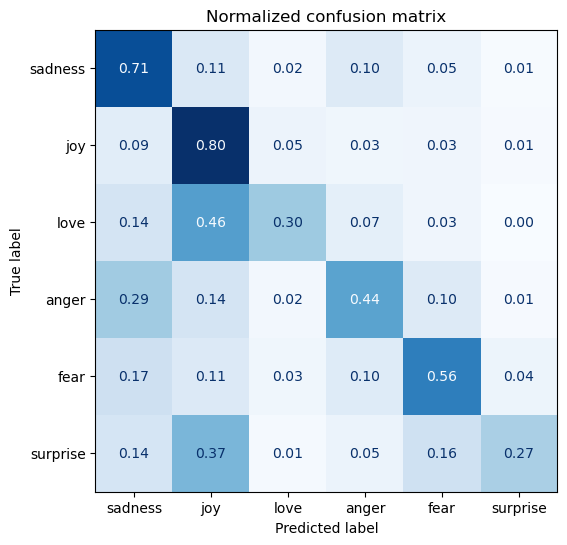

In [47]:
# 오차행렬
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
labels = emotion["train"].features["label"].names

plot_confusion_matrix(y_preds, y_valid, labels)

#### 트랜스포머 미세 튜닝하기
엔드-투-엔드로 미세튜닝하는 조건
   * 은닉 상태를 고정된 특성으로 사용하지 않고, 전체 모델 훈련
   * 분류 헤드는 미분 가능해야
<br> 

* 사전 훈련된 모델 로드하기

In [63]:
from transformers import AutoModelForSequenceClassification
# 사전 훈련된 모델 출력 위에 베이스 모델과 함께 쉽게 훈련할 수 있는 분류 헤드 있음

num_labels = 6 # 분류 헤드의 출력 크기 설정하기 위해 모델이 예측할 레이블 개수
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels = num_labels)

* 성공 지표 정의하기

In [49]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred) :
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average = 'weighted')
    acc = accuracy_score(labels, preds)
    return {'accuracy' : acc, 'f1' : f1}

* 모델 훈련하기

In [60]:
# 허브에 로그인
from huggingface_hub import notebook_login
notebook_login()

In [78]:
from transformers import Trainer, TrainingArguments # 많은 정보 저장하며 훈련과 평가 상세하게 제어

batch_size = 64
logging_steps = len(emotion_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir="/",
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  eval_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  save_strategy="epoch",
                                  load_best_model_at_end=True,
                                  log_level="error")

In [79]:
trainer = Trainer(model = model, args = training_args,
                 compute_metrics = compute_metrics,
                 train_dataset = emotion_encoded['train'],
                 eval_dataset = emotion_encoded['validation'],
                 tokenizer = tokenizer)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.812700,0.291318,0.918000,0.917286
2,0.238800,0.206207,0.924000,0.924050


TrainOutput(global_step=500, training_loss=0.5257229995727539, metrics={'train_runtime': 9315.5212, 'train_samples_per_second': 3.435, 'train_steps_per_second': 0.054, 'total_flos': 720342861696000.0, 'train_loss': 0.5257229995727539, 'epoch': 2.0})

In [80]:
preds_output = trainer.predict(emotion_encoded['validation'])
preds_output.metrics

{'test_loss': 0.20620718598365784,
 'test_accuracy': 0.924,
 'test_f1': 0.9240502622303042,
 'test_runtime': 141.8665,
 'test_samples_per_second': 14.098,
 'test_steps_per_second': 0.226}

In [81]:
# 각 클래스에 대한 예측 데이터 -> 각 큰 값이 나오도록 예측 인코딩하여 예측 레이블 반환
y_preds = np.argmax(preds_output.predictions, axis=1)

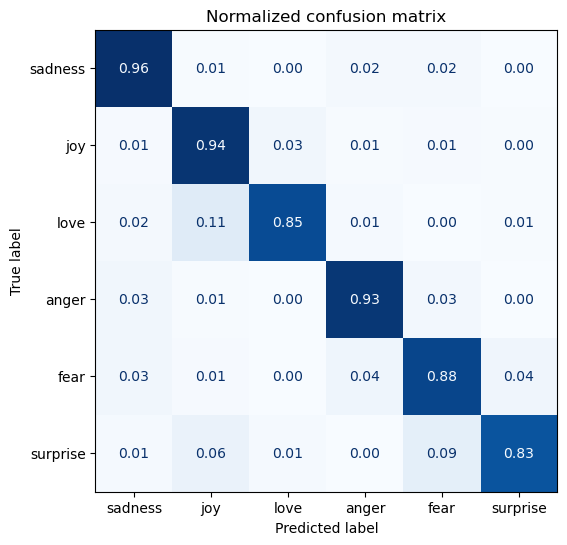

In [82]:
plot_confusion_matrix(y_preds, y_valid, labels)

* 오류 분석

In [88]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch) :
    inputs = {k:v for k, v in batch.items()
             if k in tokenizer.model_input_names}
    
    with torch.no_grad() :
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis = -1)
        loss = cross_entropy(output.logits, batch['label'], reduction='none')
        
    return {'loss' : loss.cpu().numpy(),
           'predicted_label' : pred_label.cpu().numpy()}

In [86]:
emotion_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [90]:
# 텐서로 반환
emotion_encoded.set_format('torch', columns=["input_ids", "attention_mask", "label"])

# 손실 값 계산
emotion_encoded['validation'] = emotion_encoded['validation'].map(forward_pass_with_label, batched = True, batch_size = 16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [93]:
emotion_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotion_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [94]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1963,i called myself pro life and voted for perry w...,joy,sadness,5.580802
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.314128
1801,i feel that he was being overshadowed by the s...,love,sadness,5.270081
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.223378
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.877756
1509,i guess this is a memoir so it feels like that...,joy,fear,4.837835
1950,i as representative of everything thats wrong ...,surprise,sadness,4.784700
882,i feel badly about reneging on my commitment t...,love,sadness,4.761225
1274,i am going to several holiday parties and i ca...,joy,sadness,4.658373
405,i have been feeling extraordinarily indecisive...,fear,joy,4.408792


In [95]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
133,i and feel quite ungrateful for it but i m loo...,sadness,sadness,0.015015
1140,i do think about certain people i feel a bit d...,sadness,sadness,0.015112
1861,im tired of feeling lethargic hating to work o...,sadness,sadness,0.015156
1310,i feel like an ungrateful asshole,sadness,sadness,0.015213
1452,i always feel guilty and come to one conclusio...,sadness,sadness,0.015517
69,i have no extra money im worried all of the ti...,sadness,sadness,0.015573
21,i feel try to tell me im ungrateful tell me im...,sadness,sadness,0.015640
1510,i feel so beaten down and defeated,sadness,sadness,0.015701
1120,i am feeling a little disheartened,sadness,sadness,0.015771
1312,i wont say the insecure feelings are gone but ...,sadness,sadness,0.015773
